# Integrating models with 0.5 as weights 


### Load Images Model and make the prediction:

In [10]:
from models.Images_classifier import Show_pred_BIT
import tensorflow as tf

In [2]:
import tensorflow_hub as hub
# Load saved model
saved_module = hub.KerasLayer("BiT1011/", trainable=True)

In [3]:
def get_pred_img(file_path):
    L=Show_pred_BIT.predict_image_logit(saved_module,correct_label=0, file_path=file_path)
    if len(L.shape) > 1:
            L = tf.reshape(L, [-1])
    MAX_PREDS = 2
    LABELS_N=["Depressed","Not Depressed"]
    classes = []
    scores = []
    logits_max = np.max(L)
    softmax_denominator = np.sum(np.exp(L - logits_max))
    for index, j in enumerate(np.argsort(L)[-MAX_PREDS::][::-1]):
        score = 1.0/(1.0 + np.exp(-L[j]))
        classes.append(LABELS_N[j])
        scores.append(np.exp(L[j] - logits_max)/softmax_denominator)
    if classes[0]=="Depressed":
        pred_p=scores[0]
        pred_n=scores[1]
    else:
        pred_p=scores[1]
        pred_n=scores[0]
    return(pred_n,pred_p)

In [102]:
D,N=get_pred_img("data/Data_for_multimodal_test/1.jpg")

## Load Text Model and make the prediction:

In [4]:
classes_index = {
    1 : "Depressed",
    0 : "Not depressed"
}
from tensorflow import keras
import pickle
model = keras.models.load_model('Exp_prep_10k_32ep/model_BiGloVe.h5')
# loading
with open('Exp_prep_10k_32ep/tokenizer_BiGlove.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [23]:
test_texts=["So been drawing a lot of stuff recently that I can’t share here, but I can share doodles of my WOL from #ff14  Kade. Who has a crush on @Behaxeltzi ‘s boy and his sister Rheila. pic.twitter.com/RrridlgIHJ",
           " Given the #Corona lock-in's, I decided to put up one of my #criticalrole linearts that people can download for free to colour! If you do please do feel free to tag me in any posts online.  I do sell and plan to release more large scale packs at  https://gumroad.com/lissyraine  pic.twitter.com/If5UauncoL"
           ,
            "NOT THE SKINNY ASS WRIST, VEINS AND THE HANDCUFF BRACELET😭😭 DONRY HOURS pic.twitter.com/9DGuLfh6A4"
           ,"😍Found this on a client's bookshelf. Of course I read what I could in the short time I was there. Even though I already read #AliceInWonderland before😁 #aiw #Reading #books #storytime #booklover pic.twitter.com/cKpk76ecq2",
            "Found a gigantic #connect4 game during our #homeschool field trip. We couldn't resist😁 #homeschooling #boardgame pic.twitter.com/J8EkvYQfVC",
            "#Nanny #nannylife #Reading #book #BookRecommendations #Halloween #abcs #alphabet pic.twitter.com/BNcMmW9eM9  " 
           ]
Labels_profile=["Depressed","Depressed","Depressed","Not Depressed","Not Depressed","Not Depressed"]


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
def predict_tweet_BiGlove(text_to_predict):
    test_sequence = tokenizer.texts_to_sequences([text_to_predict])
    test_data = pad_sequences(test_sequence, maxlen=197)
    predictions = model.predict(test_data)
    prediction = np.argmax(predictions)
    pred_n=predictions[0][0]
    pred_p=predictions[0][1]
    return(pred_n,pred_p)

In [98]:
pred1 , pred2 =predict_tweet_BiGlove(test_texts[1])
pred1, pred2

(0.1750907, 0.8249093)

## Multimodal:

This approach supposes that a social network user posts an image and a photo to express himself giving the same importance to both.


In [25]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

In [26]:
def multimodal_pred_post(file_path, text_to_predict,label):
    # Calculate prob with a multimodal aspect
    pred_text_N, pred_text_P=predict_tweet_BiGlove(text_to_predict)
    pred_Image_N, pred_Image_P=get_pred_img(file_path)
    Pred_multimodal_N=0.5*pred_text_N+0.5*pred_Image_N
    Pred_multimodal_P=0.5*pred_text_P+0.5*pred_Image_P
    # print both img and status 
    print("The person who posted this is",label)
    print()
    print(text_to_predict)
    img = cv2.imread(file_path)
    plt.imshow(img)
    plt.show()
    print()
    print("The Text prediction is ",str(round(pred_text_P*100,3)),"% Depressed and",str(round(pred_text_N*100,3)),"% Not Depressed ")
    print("The Image prediction is ",str(round(pred_Image_P*100,3)),"% Depressed and",str(round(pred_Image_N*100,3)),"% Not Depressed ")
    print("The Multimodal prediction is ",str(round(Pred_multimodal_P*100,3)),"% Depressed and",str(round(Pred_multimodal_N*100,3)),"% Not Depressed ")
    print()

 *********************************  Post number  1   ****************************
The person who posted this is Depressed

So been drawing a lot of stuff recently that I can’t share here, but I can share doodles of my WOL from #ff14  Kade. Who has a crush on @Behaxeltzi ‘s boy and his sister Rheila. pic.twitter.com/RrridlgIHJ


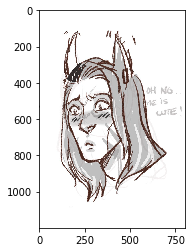


The Text prediction is  66.874 % Depressed and 33.126 % Not Depressed 
The Image prediction is  90.885 % Depressed and 9.115 % Not Depressed 
The Multimodal prediction is  78.88 % Depressed and 21.12 % Not Depressed 

 *********************************  Post number  2   ****************************
The person who posted this is Depressed

 Given the #Corona lock-in's, I decided to put up one of my #criticalrole linearts that people can download for free to colour! If you do please do feel free to tag me in any posts online.  I do sell and plan to release more large scale packs at  https://gumroad.com/lissyraine  pic.twitter.com/If5UauncoL


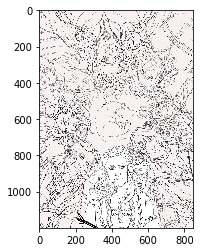


The Text prediction is  82.491 % Depressed and 17.509 % Not Depressed 
The Image prediction is  65.358 % Depressed and 34.642 % Not Depressed 
The Multimodal prediction is  73.925 % Depressed and 26.075 % Not Depressed 

 *********************************  Post number  3   ****************************
The person who posted this is Depressed

NOT THE SKINNY ASS WRIST, VEINS AND THE HANDCUFF BRACELET😭😭 DONRY HOURS pic.twitter.com/9DGuLfh6A4


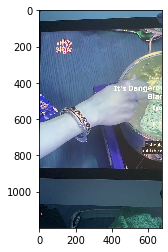


The Text prediction is  63.486 % Depressed and 36.514 % Not Depressed 
The Image prediction is  67.895 % Depressed and 32.105 % Not Depressed 
The Multimodal prediction is  65.691 % Depressed and 34.309 % Not Depressed 

 *********************************  Post number  4   ****************************
The person who posted this is Not Depressed

😍Found this on a client's bookshelf. Of course I read what I could in the short time I was there. Even though I already read #AliceInWonderland before😁 #aiw #Reading #books #storytime #booklover pic.twitter.com/cKpk76ecq2


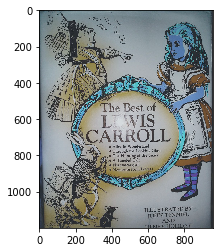


The Text prediction is  76.819 % Depressed and 23.182 % Not Depressed 
The Image prediction is  11.608 % Depressed and 88.392 % Not Depressed 
The Multimodal prediction is  44.213 % Depressed and 55.787 % Not Depressed 

 *********************************  Post number  5   ****************************
The person who posted this is Not Depressed

Found a gigantic #connect4 game during our #homeschool field trip. We couldn't resist😁 #homeschooling #boardgame pic.twitter.com/J8EkvYQfVC


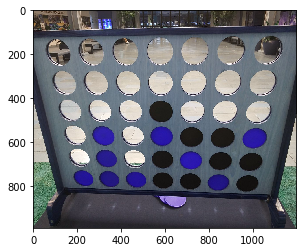


The Text prediction is  58.996 % Depressed and 41.004 % Not Depressed 
The Image prediction is  98.769 % Depressed and 1.231 % Not Depressed 
The Multimodal prediction is  78.882 % Depressed and 21.118 % Not Depressed 

 *********************************  Post number  6   ****************************
The person who posted this is Not Depressed

#Nanny #nannylife #Reading #book #BookRecommendations #Halloween #abcs #alphabet pic.twitter.com/BNcMmW9eM9  


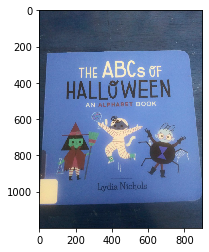


The Text prediction is  70.18 % Depressed and 29.82 % Not Depressed 
The Image prediction is  3.113 % Depressed and 96.887 % Not Depressed 
The Multimodal prediction is  36.647 % Depressed and 63.353 % Not Depressed 



In [28]:
for i in range(6):
    print(" *********************************  Post number ",str(i+1),"  ****************************")
    multimodal_pred_post("data/Data_for_multimodal_test/"+str(i+1)+".jpg",test_texts[i],Labels_profile[i])
    
